## Lectura y Limpieza

Los datos usados en este notebook estan en un google drive publico, se puede acceder al rar desde [este link](https://drive.google.com/file/d/18FPmRe_M5ajtjej-8LBExIzvyzW-wPfx/view?usp=sharing).

Descargando y extrayendo del rar debería quedar un estructura asi: `./datasets/precios/20180902/items_preciosclaros_300.csv`

In [1]:
import os
import pandas as pd

In [2]:
# Esta celda demora sus minutitos en ejecutarse
files_to_read = []
root_precios = os.path.join(".","datasets","precios")
for root, dirs, files in os.walk(root_precios):
    for fname in files:
        files_to_read.append(os.path.join(root, fname))

columnas_a_leer = ["fecha_relevamiento", "precio", "producto_id", "sucursal_id"]
precios = pd.concat((pd.read_csv(f, low_memory=False, usecols=columnas_a_leer, parse_dates=[0]) for f in files_to_read))

precios = precios[precios["precio"].notnull()]
precios["sucursal_id"] = precios["sucursal_id"].astype("category")
precios["producto_id"] = precios["producto_id"].astype("category")

# Se ejecuto en scrapper en 5 días distintos, 3 a principio de mes y 2 a final,
# para simplificar cambiamos a inicio y fin de mes.
precios["dia_relevamiento"] = precios["fecha_relevamiento"].dt.strftime('%Y-%m-%d')
precios["dia_relevamiento"] = precios["dia_relevamiento"].replace({'2018-08-31':'2018-09-01', '2018-09-02':'2018-09-01','2018-09-28':'2018-09-29'})

precios = precios.drop("fecha_relevamiento", axis="columns")

## Data Frame Comparativo para Provincia Córdoba

In [3]:
# Esto deberia ser con pivot_table pero por alguna razon se me muere la PC
df_inicio = precios[precios['dia_relevamiento'] == '2018-09-01']
df_inicio.columns = ['precio_inicio_mes', 'producto_id', 'sucursal_id', 'dia_relevamiento']
df_inicio = df_inicio.drop("dia_relevamiento", axis="columns")

df_fin = precios[precios['dia_relevamiento'] == '2018-09-29']
df_fin.columns = ['precio_fin_mes', 'producto_id', 'sucursal_id', 'dia_relevamiento']
df_fin = df_fin.drop("dia_relevamiento", axis="columns")

df_precios = df_inicio.merge(df_fin, left_on=["producto_id", "sucursal_id"], right_on=["producto_id", "sucursal_id"])
df_precios = df_precios[["producto_id", "sucursal_id", "precio_inicio_mes", "precio_fin_mes"]]
df_precios["variacion_mensual"] = round((df_precios["precio_fin_mes"] / df_precios["precio_inicio_mes"]) - 1,2)

# Filtro por quantile 0.95 para sacar outliers y cosas raras
df_precios = df_precios[df_precios.variacion_mensual < 0.33] 

#### Merge con Productos

In [4]:
productos = pd.read_csv("./datasets/productos.csv")
productos = productos.drop_duplicates() # El csv tiene muchos duplicados
df_precios = df_precios.merge(productos, left_on="producto_id", right_on="id")

df_precios["nombre"] = df_precios["nombre"].astype("category")
df_precios["marca"] = df_precios["marca"].astype("category")
df_precios["presentacion"] = df_precios["presentacion"].astype("category")
df_precios.drop("id", axis="columns", inplace=True)

#### Merge con Sucursales de Córdoba

In [5]:
sucursales = pd.read_csv("./datasets/sucursales.csv")
sucursales = sucursales[sucursales.provincia == "AR-X"]
sucursales['sucursal_id'] = sucursales.apply(lambda x: f"{x['comercioId']}-{x['banderaId']}-{x['sucursalId']}", axis=1)

cadenas = pd.read_csv('./datasets/cadenas.csv', usecols=['comercioId', 'banderaId', 'comercioRazonSocial', 'banderaDescripcion'])
cadenas.rename(dict(zip(cadenas.columns[-2:], ['empresa', 'cadena'])), inplace=True, axis="columns")
sucursales = pd.merge(sucursales, cadenas, on=['comercioId', 'banderaId'])
sucursales.drop(['provincia', 'sucursalId', 'comercioId', 'banderaId', "lat", "lng"], axis="columns", inplace=True)
sucursales.head()

df_precios = df_precios.merge(sucursales)

#### Escritura csv limpio

In [6]:
df_precios.to_csv("./datasets/analisis/cordoba_mes_de_septiembre.csv", index=False)

### Analisis

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

In [35]:
# Si queremos leer desde el csv limpio
columnas_categoricas = ['producto_id', 'sucursal_id', 'nombre', 'marca', 'presentacion', 'localidad', 'sucursalTipo', 'empresa', 'cadena']
tipo_columnas = ['category'] * len(columnas_categoricas)
col_types = dict(zip(columnas_categoricas, tipo_columnas))
df_precios = pd.read_csv("./datasets/analisis/cordoba_mes_de_septiembre.csv", low_memory=False, dtype=col_types)

In [ ]:
# Sacamos outliers inferiores
df_precios = df_precios[df_precios.variacion_mensual > -0.20]

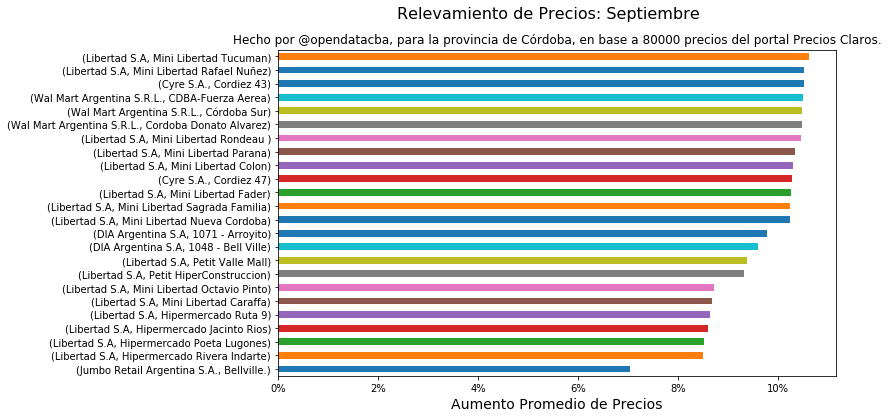

In [15]:
df_precios.groupby(["empresa","sucursalNombre"])["variacion_mensual"].mean().sort_values().plot(kind="barh")
plt.suptitle("Relevamiento de Precios: Septiembre", size=16)
plt.title("Hecho por @opendatacba, para la provincia de Córdoba, en base a 80000 precios del portal Precios Claros.")
plt.ylabel("")
plt.xlabel("Aumento Promedio de Precios", size=14)
plt.xticks([0,0.02,0.04,0.06,0.08,0.10],["0%","2%","4%", "6%", "8%", "10%"])
plt.show()

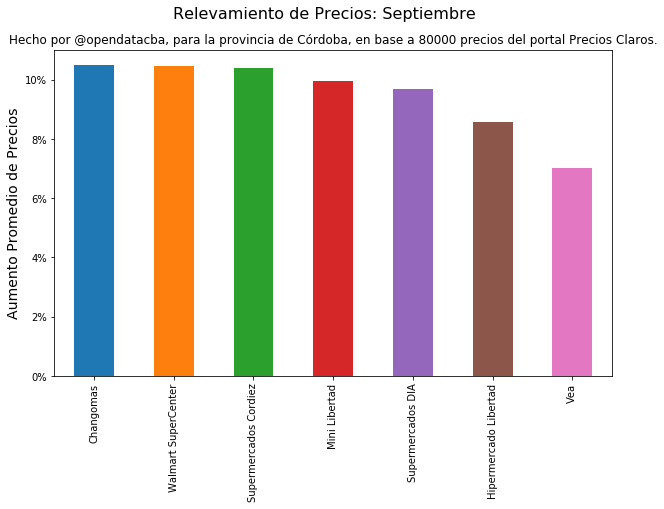

In [13]:
df_precios.groupby(["cadena"])["variacion_mensual"].mean().sort_values(ascending=False).plot(kind="bar")
plt.suptitle("Relevamiento de Precios: Septiembre", size=16)
plt.title("Hecho por @opendatacba, para la provincia de Córdoba, en base a 80000 precios del portal Precios Claros.")
plt.xlabel("")
plt.ylabel("Aumento Promedio de Precios", size=14)
plt.yticks([0,0.02,0.04,0.06,0.08,0.10],["0%","2%","4%", "6%", "8%", "10%"])
plt.show()

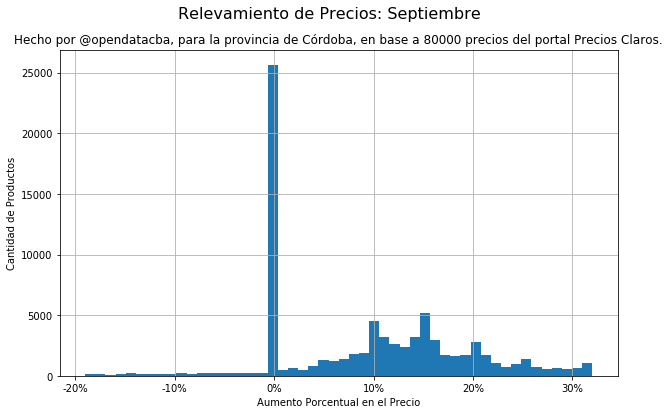

In [18]:
df_precios.variacion_mensual.hist(bins=50)
plt.suptitle("Relevamiento de Precios: Septiembre", size=16)
plt.title("Hecho por @opendatacba, para la provincia de Córdoba, en base a 80000 precios del portal Precios Claros.")
plt.ylabel("Cantidad de Productos")
plt.xlabel("Aumento Porcentual en el Precio")
plt.xticks([-0.2,-0.1,0,0.1,0.2,0.3],["-20%","-10%","0%", "10%", "20%", "30%"])
plt.show()

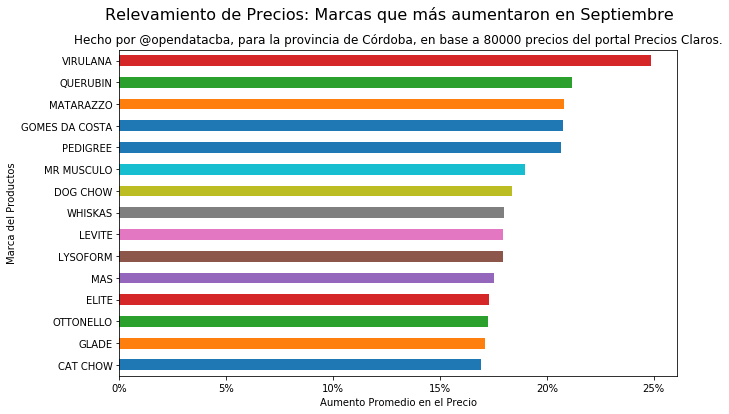

In [45]:
aumentos_marcas = df_precios.groupby("marca")["variacion_mensual"].agg({"mean", "count"}).sort_values(ascending=False, by="mean")
# Nos aseguramos que haya suficientes precios relevados como para que sea representativo el promedio
aumentos_marcas = aumentos_marcas[aumentos_marcas["count"] > 100]
aumentos_marcas.columns = ["aumento_promedio", "cantidad_precios_relevados"]

aumentos_marcas.aumento_promedio.head(15).sort_values().plot(kind="barh")
plt.suptitle("Relevamiento de Precios: Marcas que más aumentaron en Septiembre", size=16)
plt.title("Hecho por @opendatacba, para la provincia de Córdoba, en base a 80000 precios del portal Precios Claros.")
plt.ylabel("Marca del Productos")
plt.xlabel("Aumento Promedio en el Precio")
plt.xticks([0.00,0.05,0.10,0.15,0.20,0.25],["0%","5%","10%", "15%", "20%", "25%"])
plt.show()

In [47]:
df_precios[df_precios.marca == "MATARAZZO"].sort_values(by="variacion_mensual", ascending=False)

,producto_id,sucursal_id,precio_inicio_mes,precio_fin_mes,variacion_mensual,nombre,marca,presentacion,localidad,sucursalNombre,direccion,sucursalTipo,empresa,cadena
544,7790070320858,15-1-1048,38.99,51.59,0.32,Matarazzo Spaghetti Integral 500 Gr,MATARAZZO,500.0 gr,Bell Ville,1048 - Bell Ville,Cl Cordoba 602,Supermercado,DIA Argentina S.A,Supermercados DIA
2674,7790070318060,15-1-1048,38.99,51.59,0.32,Fideos Tirabuzones con 3 Vegetales Matarazzo 5...,MATARAZZO,500.0 gr,Bell Ville,1048 - Bell Ville,Cl Cordoba 602,Supermercado,DIA Argentina S.A,Supermercados DIA
54433,7790070318060,7-1-43,38.22,50.64,0.32,Fideos Tirabuzones con 3 Vegetales Matarazzo 5...,MATARAZZO,500.0 gr,CARLOS PAZ,Cordiez 43,Av. San Martin 1906,Supermercado,Cyre S.A.,Supermercados Cordiez
6042,7790070318060,15-1-1071,38.99,51.59,0.32,Fideos Tirabuzones con 3 Vegetales Matarazzo 5...,MATARAZZO,500.0 gr,Arroyito,1071 - Arroyito,Av Arturo Illia 796,Supermercado,DIA Argentina S.A,Supermercados DIA
58954,7790070318749,7-1-47,38.22,50.64,0.32,Fideos Spaghetti con Morron Matarazzo 500 Gr,MATARAZZO,500.0 gr,CAPILLA DEL MONTE,Cordiez 47,Hipolito Yrigoyen 262,Supermercado,Cyre S.A.,Supermercados Cordiez
3909,7790070320858,15-1-1071,38.99,51.59,0.32,Matarazzo Spaghetti Integral 500 Gr,MATARAZZO,500.0 gr,Arroyito,1071 - Arroyito,Av Arturo Illia 796,Supermercado,DIA Argentina S.A,Supermercados DIA
55027,7790070318749,7-1-43,38.22,50.64,0.32,Fideos Spaghetti con Morron Matarazzo 500 Gr,MATARAZZO,500.0 gr,CARLOS PAZ,Cordiez 43,Av. San Martin 1906,Supermercado,Cyre S.A.,Supermercados Cordiez
58530,7790070318077,7-1-47,38.22,50.64,0.32,Fideos Mostacholes 3 Vegetales Matarazzo 500 Gr,MATARAZZO,500.0 gr,CAPILLA DEL MONTE,Cordiez 47,Hipolito Yrigoyen 262,Supermercado,Cyre S.A.,Supermercados Cordiez
72197,7790070317476,16-2-4604,101.00,132.00,0.31,Lasagna Matarazzo 500 Gr,MATARAZZO,500.0 gr,Capital,Mini Libertad Caraffa,Av. Emilio Caraffa 2683,Autoservicio,Libertad S.A,Mini Libertad
73258,7790070317476,16-2-5104,101.00,132.00,0.31,Lasagna Matarazzo 500 Gr,MATARAZZO,500.0 gr,Capital,Mini Libertad Colon,Av. Colon 823,Autoservicio,Libertad S.A,Mini Libertad
